<a href="https://colab.research.google.com/github/MichM072/ScriptieRec/blob/main/Scriptie_librec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pip installations
import os

local = os.path.isdir('data/movielens_100k/ml-100k/')

if local:
  path = 'data/movielens_100k/ml-100k/'
else:
  if not os.path.isdir('/content/drive/MyDrive/ml-100k/'):
    from google.colab import drive
    drive.mount('/content/drive')
  path = '/content/drive/MyDrive/ml-100k/'

if not local:
  !pip install surprise
  !pip install LibRecommender
  !pip install ray -U "ray[tune]"

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193667 sha256=84da8665b53f6de62641d51af83aeb0f4544c3d070bd0d83f978f6d4fc90d594
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 23.0 MB/s eta 

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gc
from surprise import Dataset
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import DistanceMetric
from sklearn import preprocessing
import tensorflow as tf

In [ ]:
user_cols = ['userId',  'age',  'gender',  'occupation',  'zip code']
user_data = pd.read_csv(path + 'u.user', sep='|', names=user_cols)

rating_cols = ['userId' , 'itemId','rating', 'timestamp']
rating_matrix = pd.read_csv(path + 'u.data', sep='\t', names=rating_cols).sort_values(by='userId', ascending=True).reset_index(drop=True)

item_cols = ['itemId', 'movieTitle', 'releaseDate', 'videoReleaseDate', 
        'IMDb-URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_matrix = pd.read_csv(path + 'u.item', sep='|', names = item_cols, encoding = 'unicode_escape', engine ='python')

In [ ]:
df_data = rating_matrix.merge(user_data, on='userId').merge(item_matrix, on='itemId')

df_data.head()

,userId,itemId,rating,timestamp,age,gender,occupation,zip code,movieTitle,releaseDate,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,55,5,875072688,24,M,technician,85711,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
1,8,55,5,879362286,36,M,administrator,05201,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
2,16,55,5,877717956,21,M,entertainment,10309,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
3,23,55,4,874785624,30,F,artist,48197,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
4,24,55,5,875323308,21,F,artist,94533,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
df_data.shape

(100000, 31)

In [ ]:
df_data['timestamp'].min()

874724710

In [ ]:
df_datetime = pd.to_datetime(df_data['timestamp'],unit='s')

df_datetime.min()

Timestamp('1997-09-20 03:05:10')

In [ ]:
day_split = 86400

from libreco.data import random_split

df_data = df_data.rename(columns = {'userId': 'user', 'itemId' : 'item', 'rating': 'label', 'timestamp': 'time'})

# df_data2

# split data into three folds for training, evaluating and testing
# first_half_data = df_data[: (len(df_data) // 2)]
train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1], seed=42)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
df_data['releaseDate']

0        01-Jan-1994
1        01-Jan-1994
2        01-Jan-1994
3        01-Jan-1994
4        01-Jan-1994
            ...     
99995    06-Feb-1998
99996    06-Feb-1998
99997    01-Jan-1998
99998    01-Jan-1994
99999    08-Mar-1996
Name: releaseDate, Length: 100000, dtype: object

In [ ]:
from libreco.data import DatasetPure

# sparse_col = ["gender", "occupation", "zip code", 
#               'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# dense_col = ["age"]
# user_col = ['age', 'gender', 'occupation', 'zip code']
# item_col = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [ ]:
from libreco.algorithms import SVD
from libreco.evaluation import evaluate

In [ ]:
# import itertools

# test_grid = {
#     'epochs' : [10, 20, 30],
#     'reg' : [2, 4]
# }

# # print(list(test_grid.keys()))
# # allNames = sorted(test_grid)
# # print(allNames)
# # combinations = itertools.product(*(test_grid[Name] for Name in allNames))
# # print(list(combinations))

# keys, values = zip(*test_grid.items())
# permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# for combination in permutations_dicts:
#   for key in combination:
#     print(combination[key])
#   print(combination)

In [ ]:
# import copy

# def gridsearch(model, param_grid, **kwargs):

#   target_model = model

#   best_config = []
#   best_eval = 1000

#   keys, values = zip(*param_grid.items())
#   combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

#   for configuration in combinations:

#     # reset graph
#     tf.compat.v1.reset_default_graph()

#     # Initialize estimator model
#     est = target_model(**kwargs)

#     pre_reg_conf = copy.copy(configuration)

#     for attribute in configuration:
#       if attribute == 'reg' and attribute is not None:
#         configuration[attribute] = tf.keras.regularizers.l2(configuration[attribute])
#       setattr(est, attribute, configuration[attribute])

#     print(f'Configuration completed, training: {target_model.__name__}')
#     print(f'Current configuration: {pre_reg_conf}')

#     with tf.device('/GPU:0'):

#       est.fit(
#           train_data,
#           verbose=0,
#           shuffle=True,
#       )

#     evaluation = evaluate(model=est, data=eval_data, metrics=["rmse"])
#     if evaluation['rmse'] < best_eval:
#       best_eval = evaluation['rmse']
#       best_config = configuration

#   return (best_config, best_eval)

In [ ]:
test = {'rmse': 100}

test['rmse']

100

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10],
#     'reg': [0.2],
#     'lr': [0.004],
#     'embed_size': [10, 100]
# }

# defaults = {'task': 'ranking',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# gridsearch(SVD, param_grid, task="rating",
#     data_info=data_info,
#     loss_type="cross_entropy",
#     lr=1e-3,
#     batch_size=2048)

In [ ]:
print(1e-5)

1e-05


In [ ]:
# for reg in [None, 0.000002, 0.00002, 0.0002, 0.002, 0.02]:
#   tf.compat.v1.reset_default_graph()
#   model = SVD(
#     task="rating",
#     data_info=data_info,
#     n_epochs=1,
#     loss_type="cross_entropy",
#     lr=0.03,
#     reg=reg,
#     batch_size=2048,
# )
#   model.fit(
#       train_data,
#       verbose=2,
#       shuffle=True,
#       eval_data=eval_data,
#       metrics=['rmse'],
#   )

In [ ]:
# tf.compat.v1.reset_default_graph()

# model = SVD(
#     task="rating",
#     data_info=data_info,
#     embed_size = 100,
#     n_epochs=20,
#     loss_type="cross_entropy",
#     lr = 0.001,
#     reg = 0.02,
#     batch_size=2048,
# )

# model.fit(
#     train_data,
#     verbose=0,
#     shuffle=True,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# model.get_item_embedding(1)

In [ ]:
from libreco.evaluation import evaluate
# evaluate(model=model, data=test_data, metrics=['rmse'])

In [ ]:
from libreco.algorithms import (
    ALS,
    SVD,
    ItemCF,
    SVDpp,
    UserCF,
)

In [ ]:
def create_regs(regs):
  regulators = [tf.keras.regularizers.l2(reg) for reg in regs]
  regulators.append(None)
  return regulators

In [ ]:
!pip install hpbandster ConfigSpace
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 KB 12.6 MB/s eta 0:00:00
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80008 sha256=e735b91ea6cf7d0611ac899fcaac77e29eb71c5a80cac6e488fd40b61a7ddddf
  Stored in directory: /root/.cache/pip/wheels/00/1a/64/46fd18498e6be998858d9f0586e5ba66318d30139fd8c8962b
Successfully built hpbandster
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ray import tune, air
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.air import session
import ConfigSpace as CS

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   svd = SVD(
#       "rating",
#       data_info,
#       loss_type="cross_entropy",
#       embed_size=config['embed_size'],
#       n_epochs=config['n_epochs'],
#       lr=config['lr'],
#       reg=config['reg'],
#       batch_size=256,
#   )
#   svd.fit(
#     train_data,
#     verbose=2,
#     shuffle=True,
#   )
#   accuracy = evaluate(model=svd, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#     'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#     'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#     'embed_size': tune.choice([10, 20, 50, 75, 100])}

# Bhob = TuneBOHB()
# Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
# scheduler = HyperBandForBOHB(
#     time_attr="training_iteration",
#     max_t=100,
#     reduction_factor=4,
#     stop_last_trials=False,
# )

# svd_tuner = tune.Tuner(
#     tune.with_resources(
#         objective, resources={"cpu": 2, "gpu": 0.5}
#     ),
#     # objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=Bhob,
#         num_samples=40,
#         scheduler=scheduler,
#     ),
#         run_config=air.RunConfig(
#         name="bohb_exp",
#         stop={"training_iteration": 100},
#     ),
#     param_space=search_space,
# )
# results = svd_tuner.fit()

In [ ]:
# svd_tuner.get_results().get_best_result()

In [ ]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   svdpp = SVDpp(
#       "rating",
#       data_info,
#       loss_type="cross_entropy",
#       embed_size=config['embed_size'],
#       n_epochs=config['n_epochs'],
#       lr=config['lr'],
#       reg=config['reg'],
#       batch_size=256,
#   )
#   svdpp.fit(
#     train_data,
#     verbose=2,
#     shuffle=True,
#   )
#   accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#     'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#     'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#     'embed_size': tune.choice([10, 20, 50, 75, 100])}

# Bhob = TuneBOHB()
# Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
# scheduler = HyperBandForBOHB(
#     time_attr="training_iteration",
#     max_t=100,
#     reduction_factor=4,
#     stop_last_trials=False,
# )

# svdpp_tuner = tune.Tuner(
#     tune.with_resources(
#         objective, resources={"cpu": 2, "gpu": 0.5}
#     ),
#     # objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=Bhob,
#         num_samples=40,
#         scheduler=scheduler,
#     ),
#         run_config=air.RunConfig(
#         name="bohb_exp",
#         stop={"training_iteration": 100},
#     ),
#     param_space=search_space,
# )
# results = svdpp_tuner.fit()

In [ ]:
# svdpp_tuner.get_results().get_best_result()

In [ ]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   als = ALS(
#       "rating",
#       data_info,
#       embed_size=config['embed_size'],
#       n_epochs=config['n_epochs'],
#       reg=config['reg'],
#   )
#   als.fit(
#     train_data,
#     verbose=2,
#     shuffle=True,
#   )
#   accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'n_epochs': tune.choice([10, 25, 50, 75, 100, 150, 200]),
#     'reg': tune.quniform(0.0, 20.0, 1.0),
#     'embed_size': tune.choice([10, 20, 50, 75, 100, 150, 200])}

# Bhob = TuneBOHB()
# Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
# scheduler = HyperBandForBOHB(
#     time_attr="training_iteration",
#     max_t=100,
#     reduction_factor=4,
#     stop_last_trials=False,
# )

# als_tuner = tune.Tuner(
#     tune.with_resources(
#         objective, resources={"cpu": 2, "gpu": 0.5}
#     ),
#     # objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=Bhob,
#         num_samples=40,
#         scheduler=scheduler,
#     ),
#         run_config=air.RunConfig(
#         name="bohb_exp",
#         stop={"training_iteration": 100},
#     ),
#     param_space=search_space,
# )
# results = als_tuner.fit()

In [ ]:
# als_tuner.get_results().get_best_result()

In [ ]:
# tf.compat.v1.reset_default_graph()
# als = ALS(
#     "rating",
#     data_info,
#     embed_size=10,
#     n_epochs=100,
#     reg=5.0,
# )
# als.fit(
#   train_data,
#   verbose=2,
#   shuffle=True,
# )
# accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'])

# print(accuracy)

In [ ]:
# tf.compat.v1.reset_default_graph()
# user_cf = UserCF(
#     "rating",
#     data_info,
#     sim_type='cosine',
#     k_sim=25,
# )
# user_cf.fit(
#   train_data,
#   verbose=0,
# )
# accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'])
# acc = accuracy['rmse']

In [ ]:
# print(acc)

In [ ]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   item_cf = ItemCF(
#       "rating",
#       data_info,
#       sim_type=config['sim_type'],
#       k_sim=config['k_sim'],
#   )
#   item_cf.fit(
#     train_data,
#     verbose=0,
#   )
#   accuracy = evaluate(model=item_cf, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'sim_type': tune.choice(['pearson', 'cosine']),
#                 'k_sim': tune.choice([10, 25, 50, 75, 100])}

# Bhob = TuneBOHB()
# Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
# scheduler = HyperBandForBOHB(
#     time_attr="training_iteration",
#     max_t=100,
#     reduction_factor=4,
#     stop_last_trials=False,
# )

# item_cf_tuner = tune.Tuner(
#     tune.with_resources(
#         objective, resources={"cpu": 2, "gpu": 0.5}
#     ),
#     # objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=Bhob,
#         num_samples=20,
#         scheduler=scheduler,
#     ),
#         run_config=air.RunConfig(
#         name="bohb_exp",
#         stop={"training_iteration": 100},
#     ),
#     param_space=search_space,
# )
# item_cf_results = item_cf_tuner.fit()

In [ ]:
# print("Best hyperparameters found were: ", item_cf_results.get_best_result().config)
# item_cf_tuner.get_results().get_best_result()

In [ ]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   user_cf = UserCF(
#       "rating",
#       data_info,
#       sim_type=config['sim_type'],
#       k_sim=config['k_sim'],
#   )
#   user_cf.fit(
#     train_data,
#     verbose=0,
#   )
#   accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'sim_type': tune.choice(['pearson', 'cosine']),
#                 'k_sim': tune.choice([10, 25, 50, 75, 100])}

# Bhob = TuneBOHB()
# Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
# scheduler = HyperBandForBOHB(
#     time_attr="training_iteration",
#     max_t=100,
#     reduction_factor=4,
#     stop_last_trials=False,
# )

# user_cf_tuner = tune.Tuner(
#     tune.with_resources(
#         objective, resources={"cpu": 2, "gpu": 0.5}
#     ),
#     # objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=Bhob,
#         num_samples=20,
#         scheduler=scheduler,
#     ),
#         run_config=air.RunConfig(
#         name="bohb_exp",
#         stop={"training_iteration": 100},
#     ),
#     param_space=search_space,
# )
# user_cf_results = user_cf_tuner.fit()

In [ ]:
# print("Best hyperparameters found were: ", user_cf_results.get_best_result().config)
# user_cf_tuner.get_results().get_best_result()

In [ ]:
# tf.compat.v1.reset_default_graph()

# model_1 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
#     lower_upper_bound = (0,5)
# )

# model_1.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# accuracy_m1 = evaluate(model=model_1, data=test_data, metrics=['rmse'])

In [ ]:
# tf.compat.v1.reset_default_graph()

# model_2 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
# )

# model_2.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )
# accuracy_m2 = evaluate(model=model_2, data=test_data, metrics=['rmse'])

In [ ]:
# print(accuracy_m1, accuracy_m2)

In [ ]:
# !zip -r root.zip /root/ 

In [ ]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   svdpp = SVDpp(
#       "rating",
#       data_info,
#       loss_type="cross_entropy",
#       embed_size=config['embed_size'],
#       n_epochs=config['n_epochs'],
#       lr=config['lr'],
#       reg=config['reg'],
#       batch_size=256,
#   )
#   svdpp.fit(
#     train_data,
#     verbose=2,
#     shuffle=True,
#   )
#   accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#     'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#     'reg': tune.choice([None, 1e-4, 2e-4, 3e-4]),
#     'embed_size': tune.choice([10, 20, 50, 75, 100])}

# algo = HyperOptSearch()

# svdpp_tuner = tune.Tuner(
#     objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=algo,
#         num_samples=20,
#     ),
#     param_space=search_space,
# )
# results = svdpp_tuner.fit()

# svdpp_tuner.get_results().get_best_result()

In [ ]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10, 25, 50, 75, 100],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# param_grid2 = {
#     'n_epochs': [10, 25, 50],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# defaults = {'task': 'rating',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# performance = []


# config, eval = gridsearch(SVD, param_grid, task="rating",
#       data_info=data_info)
# print(f'Finished {model}')
# result = ('SVD', config, eval)
# performance.append(result)
# print('Fully finished!')

In [ ]:
# print(performance)

In [ ]:
df_data.head()

,user,item,label,time,age,gender,occupation,zip code,movieTitle,releaseDate,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,55,5,875072688,24,M,technician,85711,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
1,8,55,5,879362286,36,M,administrator,05201,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
2,16,55,5,877717956,21,M,entertainment,10309,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
3,23,55,4,874785624,30,F,artist,48197,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
4,24,55,5,875323308,21,F,artist,94533,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
from libreco.data import split_by_num_chrono

def create_timesets(data, increments = 1, test_num = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    temp_data = data.loc[data['time'] <= train_days]

    train_set, test_set = split_by_num_chrono(temp_data, test_size=test_num)

    test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
    train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [ ]:
def create_timesets2(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    train_set = data.loc[data['time'] <= train_days]
    test_set = data.loc[(data['time'] > train_days) & (data['time'] <= train_days + day_split * test_days)]

    test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
    train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [ ]:
test_df = df_data.loc[df_data['time'] < 875072688]

test_df

,user,item,label,time,age,gender,occupation,zip code,movieTitle,releaseDate,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
3,23,55,4,874785624,30,F,artist,48197,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
49,276,55,4,874792366,21,M,student,95064,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
51,291,55,4,874834735,19,M,student,44106,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
63,346,55,5,874948639,34,M,other,76059,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
94,506,55,4,874873287,46,M,programmer,03869,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99590,291,1505,4,874868647,19,M,student,44106,Killer: A Journal of Murder (1995),06-Sep-1996,...,0,0,0,0,0,0,0,0,0,0
99667,543,1524,4,874866319,33,M,scientist,95123,Kaspar Hauser (1993),07-Jun-1996,...,0,0,0,0,0,0,0,0,0,0
99827,543,1555,3,874863155,33,M,scientist,95123,"Secret Adventures of Tom Thumb, The (1993)",01-Jan-1993,...,0,0,0,0,0,0,0,0,0,0
99901,543,1619,3,874865635,33,M,scientist,95123,All Things Fair (1996),08-Mar-1996,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train, test, temppp = create_timesets(df_data, increments=10, test_num = 1, stop = 5)

for temp in temppp:
  print(temp / 86400)

10.0
20.0
30.0
40.0
50.0


In [ ]:
for tr, te in zip(train, test):
  print(tr.shape)
  print(te.shape)

(6007, 31)
(69, 31)
(10083, 31)
(110, 31)
(13659, 31)
(151, 31)
(16041, 31)
(181, 31)
(20144, 31)
(216, 31)


In [ ]:
kaas1, kaas2 = split_by_num_chrono(df_data, test_size = 1)
kaas1, data_kaas = DatasetPure.build_trainset(kaas1)
kaas2 = DatasetPure.build_testset(kaas2)

for user in kaas1.user_indices:
  if user not in kaas2.user_indices:
    print(user)

333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333
333


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
test = {'Day 1': {'SVD': {'precision': 0.09759825327510918, 'recall': 0.11243680555691093, 'map': 0.2329821183082646, 'ndcg': 0.32328197069467746}, 'SVDpp': {'precision': 0.09574235807860262, 'recall': 0.11352322985020856, 'map': 0.23240755181257364, 'ndcg': 0.3232181370376707}, 'ItemCF': {'precision': 0.030895196506550218, 'recall': 0.04874355087375927, 'map': 0.0974498336452485, 'ndcg': 0.13003226035468538}, 'UserCF': {'precision': 0.0027292576419213977, 'recall': 0.0021887008976569536, 'map': 0.006925816177999584, 'ndcg': 0.011535077285933745}, 'ALS': {'precision': 0.12827510917030568, 'recall': 0.18282404703448726, 'map': 0.2724576243039671, 'ndcg': 0.38393204203985315}}}



In [ ]:
def model_results(results, metrics, nth_ticks=2):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    # fig.savefig("test.png")
    plt.legend()
    plt.show()

In [ ]:
def check_sim(train, test):
  print(train['user'].isin(test['user']).value_counts())
  print(test['user'].isin(train['user']).value_counts())

In [ ]:
import time as t

In [ ]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):

  results = {}

  for algo in algos:
    print(algo)
    result = evaluate(model=algo, data=test_data, metrics=metrics)
    results[algo.__class__.__name__] = result

  return results

def run_experiment(data, increments, test_days, stop, ignore_remainder = True, task = 'ranking'):

  metrics_rating = [
      "rmse"
  ]

  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

  if task == 'ranking':
    metrics = metrics_ranking
  else:
    metrics = metrics_rating

  train, test, temporal_data = create_timesets(data, increments, test_days, stop, ignore_remainder)

  temporal_results = {}

  i = 0

  for train, test in zip(train, test):

    # print('testing')

    # print('########## CHECKING SIM ###########')
    # print('########## train users in test set ##########')
    # print(train['user'].isin(test['user']).value_counts())
    # print('########## test users in train set ##########')
    # print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)
    test_data = DatasetPure.build_testset(test)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=20,
        n_epochs=50,
        lr=0.001,
        reg=0.0001,
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
    )

    svd_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=50,
        n_epochs=25,
        lr=0.001,
        reg=0.0001,
    )

    svdpp.fit(
        train_data,
        verbose=0,
    )

    svdpp_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=25,
        sim_type="cosine",
    )

    item_cf.fit(
        train_data,
        verbose=0
    )

    item_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=50,
        sim_type="cosine",
    )

    user_cf.fit(
        train_data,
        verbose=0,
    )

    user_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=10,
        n_epochs=200,
        reg=5.0
    )

    als.fit(
        train_data,
        verbose=0,
    )

    als_time = t.perf_counter() - start

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    time = int(temporal_data[i] / 86400)

    temporal_results[str(time)] = create_results(algos, test_data, metrics)

    for times in timers:
      temporal_results[str(time)][times[0]]['train_time'] = times[1]

    i+=1

  return temporal_results


In [ ]:
test_run44 = run_experiment(df_data, 10, 1, 1, ignore_remainder = True, task = 'rating')

print(test_run44)


 ============================== SVD ==============================
Training start time: 2023-04-03 21:51:56


train: 100%|██████████| 24/24 [00:00<00:00, 911.67it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 21:51:58


train: 100%|██████████| 24/24 [00:00<00:00, 497.41it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 21:52:00
Final block size and num: (1015, 1)
sim_matrix elapsed: 0.018s
sim_matrix, shape: (1015, 1015), num_elements: 450380, density: 9459.7774 %


top_k: 100%|██████████| 1015/1015 [00:00<00:00, 5912.02it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 21:52:00
Final block size and num: (69, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (69, 69), num_elements: 4228, density: 88.8049 %


top_k: 100%|██████████| 69/69 [00:00<00:00, 27024.65it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 21:52:00


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 459.75it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 3155.98it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 25.19it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1790.91it/s]

{'10': {'SVD': {'rmse': 1.4489824568150056, 'train_time': 2.0070746669989603}, 'SVDpp': {'rmse': 1.1238212378066512, 'train_time': 1.7709560980001697}, 'ItemCF': {'rmse': 1.0861509138755618, 'train_time': 0.2016638499990222}, 'UserCF': {'rmse': 1.194787821434299, 'train_time': 0.014725460001500323}, 'ALS': {'rmse': 1.3254622525294142, 'train_time': 4.3617191779994755}}}


In [ ]:
test_run = run_experiment(df_data, 10, 1, None, ignore_remainder = True, task = 'rating')

print(test_run)


 ============================== SVD ==============================
Training start time: 2023-04-03 18:03:08


train: 100%|██████████| 24/24 [00:00<00:00, 708.64it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:03:10


train: 100%|██████████| 24/24 [00:00<00:00, 446.82it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:03:12
Final block size and num: (1015, 1)
sim_matrix elapsed: 0.012s
sim_matrix, shape: (1015, 1015), num_elements: 450380, density: 9459.7774 %


top_k: 100%|██████████| 1015/1015 [00:00<00:00, 6332.88it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:03:12
Final block size and num: (69, 1)
sim_matrix elapsed: 0.003s
sim_matrix, shape: (69, 69), num_elements: 4228, density: 88.8049 %


top_k: 100%|██████████| 69/69 [00:00<00:00, 20865.68it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:03:12
0
######## 10 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1187.85it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2737.80it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 73.52it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2511.56it/s]


 ============================== SVD ==============================
Training start time: 2023-04-03 18:03:14



train: 100%|██████████| 40/40 [00:00<00:00, 1086.61it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:03:17


train: 100%|██████████| 40/40 [00:00<00:00, 701.67it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:03:19
Final block size and num: (1125, 1)
sim_matrix elapsed: 0.018s
sim_matrix, shape: (1125, 1125), num_elements: 609096, density: 5033.8512 %


top_k: 100%|██████████| 1125/1125 [00:00<00:00, 1511.35it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:03:20
Final block size and num: (110, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (110, 110), num_elements: 10842, density: 89.6033 %


top_k: 100%|██████████| 110/110 [00:00<00:00, 20884.19it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:03:20
1
######## 20 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2181.13it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2189.09it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 41.89it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]


 ============================== SVD ==============================
Training start time: 2023-04-03 18:03:21



train: 100%|██████████| 54/54 [00:00<00:00, 728.78it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:03:25


train: 100%|██████████| 54/54 [00:00<00:00, 306.41it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:03:30
Final block size and num: (1183, 1)
sim_matrix elapsed: 0.019s
sim_matrix, shape: (1183, 1183), num_elements: 677422, density: 2971.0188 %


top_k: 100%|██████████| 1183/1183 [00:00<00:00, 5374.60it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:03:30
Final block size and num: (151, 1)
sim_matrix elapsed: 0.003s
sim_matrix, shape: (151, 151), num_elements: 20994, density: 92.0749 %


top_k: 100%|██████████| 151/151 [00:00<00:00, 19514.40it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:03:30
2
######## 30 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1861.65it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1264.49it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1274.09it/s]


 ============================== SVD ==============================
Training start time: 2023-04-03 18:03:34



train: 100%|██████████| 63/63 [00:00<00:00, 607.98it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:03:38


train: 100%|██████████| 63/63 [00:00<00:00, 528.03it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:03:43
Final block size and num: (1221, 1)
sim_matrix elapsed: 0.026s
sim_matrix, shape: (1221, 1221), num_elements: 730688, density: 2230.3593 %


top_k: 100%|██████████| 1221/1221 [00:00<00:00, 7005.27it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:03:43
Final block size and num: (181, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (181, 181), num_elements: 30380, density: 92.7322 %


top_k: 100%|██████████| 181/181 [00:00<00:00, 20147.80it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:03:43
3
######## 40 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1177.51it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 665.13it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 27.35it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2470.14it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:03:46


train: 100%|██████████| 79/79 [00:00<00:00, 1148.80it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:03:50


train: 100%|██████████| 79/79 [00:00<00:00, 347.37it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:03:56
Final block size and num: (1329, 1)
sim_matrix elapsed: 0.052s
sim_matrix, shape: (1329, 1329), num_elements: 906228, density: 1942.3611 %


top_k: 100%|██████████| 1329/1329 [00:00<00:00, 4025.35it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:03:56
Final block size and num: (216, 1)
sim_matrix elapsed: 0.004s
sim_matrix, shape: (216, 216), num_elements: 43664, density: 93.5871 %


top_k: 100%|██████████| 216/216 [00:00<00:00, 16918.52it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:03:56
4
######## 50 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 972.48it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2036.07it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1790.91it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:04:00


train: 100%|██████████| 124/124 [00:00<00:00, 1236.41it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:04:06


train: 100%|██████████| 124/124 [00:00<00:00, 401.04it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:04:16
Final block size and num: (1391, 1)
sim_matrix elapsed: 0.032s
sim_matrix, shape: (1391, 1391), num_elements: 1054904, density: 881.1721 %


top_k: 100%|██████████| 1391/1391 [00:00<00:00, 5656.41it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:04:16
Final block size and num: (346, 1)
sim_matrix elapsed: 0.005s
sim_matrix, shape: (346, 346), num_elements: 112728, density: 94.1629 %


top_k: 100%|██████████| 346/346 [00:00<00:00, 13122.01it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:04:16
5
######## 60 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 727.93it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1889.33it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1603.33it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:04:20


train: 100%|██████████| 152/152 [00:00<00:00, 926.32it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:04:30


train: 100%|██████████| 152/152 [00:00<00:00, 392.64it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:04:43
Final block size and num: (1408, 1)
sim_matrix elapsed: 0.035s
sim_matrix, shape: (1408, 1408), num_elements: 1128898, density: 674.8513 %


top_k: 100%|██████████| 1408/1408 [00:00<00:00, 5354.18it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:04:43
Final block size and num: (409, 1)
sim_matrix elapsed: 0.013s
sim_matrix, shape: (409, 409), num_elements: 159064, density: 95.0879 %


top_k: 100%|██████████| 409/409 [00:00<00:00, 10893.81it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:04:43
6
######## 70 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2420.26it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1180.16it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:04:48


train: 100%|██████████| 169/169 [00:00<00:00, 1110.67it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:04:58


train: 100%|██████████| 169/169 [00:00<00:00, 351.43it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:05:12
Final block size and num: (1429, 1)
sim_matrix elapsed: 0.046s
sim_matrix, shape: (1429, 1429), num_elements: 1179974, density: 580.1220 %


top_k: 100%|██████████| 1429/1429 [00:00<00:00, 5434.92it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:05:12
Final block size and num: (451, 1)
sim_matrix elapsed: 0.008s
sim_matrix, shape: (451, 451), num_elements: 194708, density: 95.7262 %


top_k: 100%|██████████| 451/451 [00:00<00:00, 10403.24it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:05:12
7
######## 80 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1959.04it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 453.98it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1923.11it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:05:17


train: 100%|██████████| 188/188 [00:00<00:00, 976.78it/s] 



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:05:31


train: 100%|██████████| 188/188 [00:00<00:00, 333.64it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:05:47
Final block size and num: (1449, 1)
sim_matrix elapsed: 0.045s
sim_matrix, shape: (1449, 1449), num_elements: 1276264, density: 563.2830 %


top_k: 100%|██████████| 1449/1449 [00:00<00:00, 4930.31it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:05:47
Final block size and num: (476, 1)
sim_matrix elapsed: 0.018s
sim_matrix, shape: (476, 476), num_elements: 217416, density: 95.9572 %


top_k: 100%|██████████| 476/476 [00:00<00:00, 10392.32it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:05:47
8
######## 90 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 573.70it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1713.36it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2075.36it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:05:55


train: 100%|██████████| 199/199 [00:00<00:00, 787.17it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:06:05


train: 100%|██████████| 199/199 [00:00<00:00, 263.99it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:06:24
Final block size and num: (1471, 1)
sim_matrix elapsed: 0.044s
sim_matrix, shape: (1471, 1471), num_elements: 1313070, density: 512.8458 %


top_k: 100%|██████████| 1471/1471 [00:00<00:00, 4902.06it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:06:24
Final block size and num: (506, 1)
sim_matrix elapsed: 0.012s
sim_matrix, shape: (506, 506), num_elements: 246024, density: 96.0896 %


top_k: 100%|██████████| 506/506 [00:00<00:00, 9054.72it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:06:24
9
######## 100 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 324.34it/s]


Detect 1 unknown interaction(s), position: [402]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1909.97it/s]


Detect 1 unknown interaction(s), position: [402]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

Detect 1 unknown interaction(s), position: [402]


eval_pointwise:   0%|          | 0/1 [00:00<?, ?it/s]

Detect 1 unknown interaction(s), position: [402]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1488.93it/s]


Detect 1 unknown interaction(s), position: [402]

 ============================== SVD ==============================
Training start time: 2023-04-03 18:06:30


train: 100%|██████████| 221/221 [00:00<00:00, 1104.07it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:06:43


train: 100%|██████████| 221/221 [00:00<00:00, 327.39it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:07:02
Final block size and num: (1502, 1)
sim_matrix elapsed: 0.057s
sim_matrix, shape: (1502, 1502), num_elements: 1369432, density: 436.6811 %


top_k: 100%|██████████| 1502/1502 [00:00<00:00, 4960.26it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:07:02
Final block size and num: (560, 1)
sim_matrix elapsed: 0.013s
sim_matrix, shape: (560, 560), num_elements: 300864, density: 95.9388 %


top_k: 100%|██████████| 560/560 [00:00<00:00, 8763.96it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:07:03
10
######## 110 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1446.81it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1497.97it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2032.12it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:07:12


train: 100%|██████████| 238/238 [00:00<00:00, 1132.98it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:07:25


train: 100%|██████████| 238/238 [00:00<00:00, 301.83it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:07:47
Final block size and num: (1511, 1)
sim_matrix elapsed: 0.054s
sim_matrix, shape: (1511, 1511), num_elements: 1400390, density: 383.8620 %


top_k: 100%|██████████| 1511/1511 [00:00<00:00, 4267.84it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:07:47
Final block size and num: (604, 1)
sim_matrix elapsed: 0.018s
sim_matrix, shape: (604, 604), num_elements: 350112, density: 95.9695 %


top_k: 100%|██████████| 604/604 [00:00<00:00, 5181.15it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:07:47
11
######## 120 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1110.78it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1421.32it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2280.75it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:07:57


train: 100%|██████████| 252/252 [00:00<00:00, 1044.45it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:08:11


train: 100%|██████████| 252/252 [00:01<00:00, 203.22it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:08:36
Final block size and num: (1559, 1)
sim_matrix elapsed: 0.055s
sim_matrix, shape: (1559, 1559), num_elements: 1598384, density: 393.9148 %


top_k: 100%|██████████| 1559/1559 [00:00<00:00, 4215.23it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:08:36
Final block size and num: (637, 1)
sim_matrix elapsed: 0.019s
sim_matrix, shape: (637, 637), num_elements: 389794, density: 96.0630 %


top_k: 100%|██████████| 637/637 [00:00<00:00, 7430.84it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:08:36
12
######## 130 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 735.71it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1927.53it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2172.09it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:08:44


train: 100%|██████████| 268/268 [00:00<00:00, 1120.36it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:08:58


train: 100%|██████████| 268/268 [00:00<00:00, 280.89it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:09:27
Final block size and num: (1568, 1)
sim_matrix elapsed: 0.060s
sim_matrix, shape: (1568, 1568), num_elements: 1653772, density: 375.0934 %


top_k: 100%|██████████| 1568/1568 [00:00<00:00, 3947.18it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:09:27
Final block size and num: (664, 1)
sim_matrix elapsed: 0.022s
sim_matrix, shape: (664, 664), num_elements: 424132, density: 96.1977 %


top_k: 100%|██████████| 664/664 [00:00<00:00, 7384.24it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:09:27
13
######## 140 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 308.88it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1942.71it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1618.17it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:09:38


train: 100%|██████████| 276/276 [00:00<00:00, 1052.04it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:09:53


train: 100%|██████████| 276/276 [00:01<00:00, 274.48it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:10:22
Final block size and num: (1587, 1)
sim_matrix elapsed: 0.069s
sim_matrix, shape: (1587, 1587), num_elements: 1704870, density: 364.4006 %


top_k: 100%|██████████| 1587/1587 [00:00<00:00, 4002.44it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:10:23
Final block size and num: (684, 1)
sim_matrix elapsed: 0.028s
sim_matrix, shape: (684, 684), num_elements: 450266, density: 96.2403 %


top_k: 100%|██████████| 684/684 [00:00<00:00, 6497.04it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:10:23
14
######## 150 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 880.23it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1164.76it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2031.14it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:10:34


train: 100%|██████████| 296/296 [00:00<00:00, 1059.53it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:10:50


train: 100%|██████████| 296/296 [00:01<00:00, 270.02it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:11:22
Final block size and num: (1603, 1)
sim_matrix elapsed: 0.067s
sim_matrix, shape: (1603, 1603), num_elements: 1757662, density: 339.0552 %


top_k: 100%|██████████| 1603/1603 [00:00<00:00, 4187.92it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:11:22
Final block size and num: (720, 1)
sim_matrix elapsed: 0.028s
sim_matrix, shape: (720, 720), num_elements: 498862, density: 96.2311 %


top_k: 100%|██████████| 720/720 [00:00<00:00, 6437.62it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:11:22
15
######## 160 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 612.93it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1679.06it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1689.89it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:11:33


train: 100%|██████████| 309/309 [00:00<00:00, 1038.11it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:11:50


train: 100%|██████████| 309/309 [00:01<00:00, 262.16it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:12:24
Final block size and num: (1606, 1)
sim_matrix elapsed: 0.084s
sim_matrix, shape: (1606, 1606), num_elements: 1728492, density: 304.8438 %


top_k: 100%|██████████| 1606/1606 [00:00<00:00, 4220.22it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:12:25
Final block size and num: (753, 1)
sim_matrix elapsed: 0.030s
sim_matrix, shape: (753, 753), num_elements: 547096, density: 96.4881 %


top_k: 100%|██████████| 753/753 [00:00<00:00, 6024.94it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:12:25
16
######## 170 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 236.22it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 627.23it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1662.43it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:12:36


train: 100%|██████████| 320/320 [00:00<00:00, 1026.65it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:12:54


train: 100%|██████████| 320/320 [00:01<00:00, 263.94it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:13:30
Final block size and num: (1625, 1)
sim_matrix elapsed: 0.064s
sim_matrix, shape: (1625, 1625), num_elements: 1817148, density: 305.6902 %


top_k: 100%|██████████| 1625/1625 [00:00<00:00, 4014.55it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:13:30
Final block size and num: (771, 1)
sim_matrix elapsed: 0.029s
sim_matrix, shape: (771, 771), num_elements: 573686, density: 96.5085 %


top_k: 100%|██████████| 771/771 [00:00<00:00, 5626.63it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:13:31
17
######## 180 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 424.10it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1130.24it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:13:40


train: 100%|██████████| 331/331 [00:00<00:00, 1060.72it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:13:59


train: 100%|██████████| 331/331 [00:01<00:00, 240.55it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:14:36
Final block size and num: (1627, 1)
sim_matrix elapsed: 0.069s
sim_matrix, shape: (1627, 1627), num_elements: 1831744, density: 277.1301 %


top_k: 100%|██████████| 1627/1627 [00:00<00:00, 3865.56it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:14:37
Final block size and num: (813, 1)
sim_matrix elapsed: 0.027s
sim_matrix, shape: (813, 813), num_elements: 636306, density: 96.2687 %


top_k: 100%|██████████| 813/813 [00:00<00:00, 5500.90it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:14:37
18
######## 190 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 463.51it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 430.19it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1689.21it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:14:49


train: 100%|██████████| 371/371 [00:00<00:00, 727.48it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:15:10


train: 100%|██████████| 371/371 [00:02<00:00, 177.49it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:15:56
Final block size and num: (1659, 1)
sim_matrix elapsed: 0.072s
sim_matrix, shape: (1659, 1659), num_elements: 1906084, density: 225.1990 %


top_k: 100%|██████████| 1659/1659 [00:00<00:00, 3668.01it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:15:56
Final block size and num: (920, 1)
sim_matrix elapsed: 0.035s
sim_matrix, shape: (920, 920), num_elements: 813804, density: 96.1489 %


top_k: 100%|██████████| 920/920 [00:00<00:00, 5171.73it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:15:56
19
######## 200 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 599.19it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 403.76it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1696.04it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:16:08


train: 100%|██████████| 376/376 [00:00<00:00, 945.56it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:16:29


train: 100%|██████████| 376/376 [00:01<00:00, 221.50it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:17:15
Final block size and num: (1654, 1)
sim_matrix elapsed: 0.075s
sim_matrix, shape: (1654, 1654), num_elements: 1817218, density: 208.3115 %


top_k: 100%|██████████| 1654/1654 [00:00<00:00, 4005.97it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:17:16
Final block size and num: (934, 1)
sim_matrix elapsed: 0.037s
sim_matrix, shape: (934, 934), num_elements: 839872, density: 96.2763 %


top_k: 100%|██████████| 934/934 [00:00<00:00, 5066.44it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:17:16
20
######## 210 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1020.76it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1621.30it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1570.90it/s]



 ============================== SVD ==============================
Training start time: 2023-04-03 18:17:29


train: 100%|██████████| 386/386 [00:00<00:00, 687.30it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-03 18:17:50


train: 100%|██████████| 386/386 [00:01<00:00, 222.90it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-03 18:18:39
Final block size and num: (1679, 1)
sim_matrix elapsed: 0.085s
sim_matrix, shape: (1679, 1679), num_elements: 1958358, density: 221.1632 %


top_k: 100%|██████████| 1679/1679 [00:00<00:00, 3796.24it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-03 18:18:39
Final block size and num: (941, 1)
sim_matrix elapsed: 0.037s
sim_matrix, shape: (941, 941), num_elements: 852504, density: 96.2758 %


top_k: 100%|██████████| 941/941 [00:00<00:00, 4742.39it/s]



 ============================== ALS ==============================
Training start time: 2023-04-03 18:18:39
21
######## 220 ########


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 219.82it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1436.41it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1836.39it/s]

{'10': {'SVD': {'rmse': 1.4423920024180537}, 'SVDpp': {'rmse': 1.1238212378066512}, 'ItemCF': {'rmse': 1.0861509138755618}, 'UserCF': {'rmse': 1.194787821434299}, 'ALS': {'rmse': 1.3254622525294142}}, '20': {'SVD': {'rmse': 1.2713940372460066}, 'SVDpp': {'rmse': 1.2169977392448446}, 'ItemCF': {'rmse': 0.9917797068429038}, 'UserCF': {'rmse': 1.2204584183597498}, 'ALS': {'rmse': 1.3859506604026373}}, '30': {'SVD': {'rmse': 1.177087628281646}, 'SVDpp': {'rmse': 1.1478099353087243}, 'ItemCF': {'rmse': 1.060002688153739}, 'UserCF': {'rmse': 1.1709541616715777}, 'ALS': {'rmse': 1.2784778369448462}}, '40': {'SVD': {'rmse': 1.1294227372014194}, 'SVDpp': {'rmse': 1.069736063618869}, 'ItemCF': {'rmse': 0.9893173292229657}, 'UserCF': {'rmse': 1.1194306763054884}, 'ALS': {'rmse': 1.2300496773528753}}, '50': {'SVD': {'rmse': 1.1091619379163389}, 'SVDpp': {'rmse': 1.0854066062161598}, 'ItemCF': {'rmse': 1.0264592749686123}, 'UserCF': {'rmse': 1.1934723169057184}, 'ALS': {'rmse': 1.1818712515910699}}

In [ ]:
def model_results(results, metrics, nth_ticks=2, model_time=False):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  if model_time:
    metrics.append('train_time')

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    # fig.savefig("test.png")
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

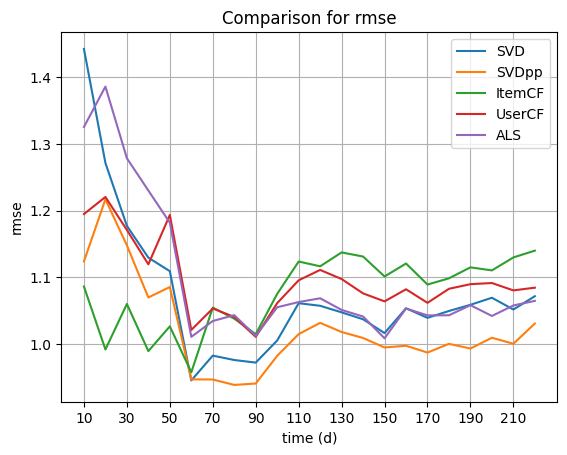

In [ ]:
test_figures = model_results(test_run, ['rmse'])

In [ ]:
# test_1 = {'test': 1, 'test2': 2}
# test_12 = {'test': 1, 'test2': 2}

# test_2 = {}
# test_2['test_3'] = test_1
# test_2['test_5'] = test_12

# test_4 = {}

# test_4['test_6'] = test_2

# print(test_4)

# for item in test_4.values():
#   print(item)

{'test_6': {'test_3': {'test': 1, 'test2': 2}, 'test_5': {'test': 1, 'test2': 2}}}
{'test_3': {'test': 1, 'test2': 2}, 'test_5': {'test': 1, 'test2': 2}}


In [ ]:
  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

test_run2 = run_experiment(df_data, 5, 5, None, ignore_remainder = True, task = 'ranking')
test_figures2 = model_results(test_run2, metrics_ranking, 4)

NameError: ignored

In [ ]:
def model_results_regular(results, metrics):
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = [results[algo][metric]]

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::2])

    # fig.savefig("test.png")
    plt.legend()
    plt.show()

In [ ]:
# def create_timesets3(train, test, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

#   train_days = df_data.time.min()
#   day_split = 86400 # day in seconds
#   train_sets = [] # list of train_set datasets
#   test_sets = [] # list of test_sets
#   temporal_data = [] # keep track of how many days have been trained on.

#   if stop == None:
#     stop = df_data.time.max()
#   else:
#     stop = train_days + day_split * increments * stop

#   while train_days < stop:
#     train_days = train_days + day_split * increments

#     train_set = train.loc[train['time'] <= train_days]
#     test_set = test.loc[(test['time'] > train_days) & (test['time'] <= train_days + day_split * test_days)]

#     test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
#     train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

#     train_sets.append(train_set)
#     test_sets.append(test_set)

#     temp_time = train_days - df_data.time.min()
#     temporal_data.append(temp_time)

#   return train_sets, test_sets, temporal_data

In [ ]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):

  results = {}

  for algo in algos:
    print(algo)
    result = evaluate(model=algo, data=test_data, metrics=metrics)
    results[algo.__class__.__name__] = result

  return results

def run_experiment_alt(data, increments, test_days, stop, ignore_remainder = True, task = 'ranking'):

  metrics_rating = [
      "rmse"
  ]

  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

  if task == 'ranking':
    metrics = metrics_ranking
  else:
    metrics = metrics_rating

  train, test, temporal_data = create_timesets2(data, increments, test_days, stop, ignore_remainder)

  temporal_results = {}

  i = 0

  for train, test in zip(train, test):

    print('testing')

    print('########## CHECKING SIM ###########')
    print('########## train users in test set ##########')
    print(train['user'].isin(test['user']).value_counts())
    print('########## test users in train set ##########')
    print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)
    test_data = DatasetPure.build_testset(test)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=20,
        n_epochs=50,
        lr=0.001,
        reg=0.0001,
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
    )

    svd_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=50,
        n_epochs=25,
        lr=0.001,
        reg=0.0001,
    )

    svdpp.fit(
        train_data,
        verbose=0,
    )

    svdpp_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=25,
        sim_type="cosine",
    )

    item_cf.fit(
        train_data,
        verbose=0
    )

    item_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=50,
        sim_type="cosine",
    )

    user_cf.fit(
        train_data,
        verbose=0,
    )

    user_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=10,
        n_epochs=200,
        reg=5.0
    )

    als.fit(
        train_data,
        verbose=0,
    )

    als_time = t.perf_counter() - start

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    time = int(temporal_data[i] / 86400)

    temporal_results[str(time)] = create_results(algos, test_data, metrics)

    for times in timers:
      temporal_results[str(time)][times[0]]['train_time'] = times[1]

    i+=1

  return temporal_results


In [ ]:
metrics_ranking = [
  "precision",
  "recall",
  "map",
  "ndcg",
]

metrics_rating = ['rmse']

test_run4 = run_experiment_alt(df_data, 10, 1, stop=None, task='rating')
test_figures4 = model_results(test_run4, metrics_rating, 2, model_time=False)

testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    649
Name: user, dtype: int64
########## test users in train set ##########
True    125
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:31:44


train: 100%|██████████| 3/3 [00:00<00:00, 486.24it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:31:45


train: 100%|██████████| 3/3 [00:00<00:00, 304.94it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:31:46
Final block size and num: (466, 1)
sim_matrix elapsed: 0.005s
sim_matrix, shape: (466, 466), num_elements: 106852, density: 427408.0000 %


top_k: 100%|██████████| 466/466 [00:00<00:00, 15081.25it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:31:46
Final block size and num: (5, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (5, 5), num_elements: 20, density: 80.0000 %


top_k: 100%|██████████| 5/5 [00:00<00:00, 33825.03it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:31:46


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 242.36it/s]


Detect 74 unknown interaction(s), position: [2, 11, 12, 13, 14, 17, 21, 26, 29, 30, 32, 39, 40, 41, 43, 44, 46, 47, 48, 50, 51, 52, 53, 58, 60, 61, 64, 65, 67, 68, 69, 71, 73, 74, 75, 78, 80, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1786.33it/s]


Detect 74 unknown interaction(s), position: [2, 11, 12, 13, 14, 17, 21, 26, 29, 30, 32, 39, 40, 41, 43, 44, 46, 47, 48, 50, 51, 52, 53, 58, 60, 61, 64, 65, 67, 68, 69, 71, 73, 74, 75, 78, 80, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 31.82it/s]


Detect 74 unknown interaction(s), position: [2, 11, 12, 13, 14, 17, 21, 26, 29, 30, 32, 39, 40, 41, 43, 44, 46, 47, 48, 50, 51, 52, 53, 58, 60, 61, 64, 65, 67, 68, 69, 71, 73, 74, 75, 78, 80, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 41.86it/s]


Detect 74 unknown interaction(s), position: [2, 11, 12, 13, 14, 17, 21, 26, 29, 30, 32, 39, 40, 41, 43, 44, 46, 47, 48, 50, 51, 52, 53, 58, 60, 61, 64, 65, 67, 68, 69, 71, 73, 74, 75, 78, 80, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 423.71it/s]

Detect 74 unknown interaction(s), position: [2, 11, 12, 13, 14, 17, 21, 26, 29, 30, 32, 39, 40, 41, 43, 44, 46, 47, 48, 50, 51, 52, 53, 58, 60, 61, 64, 65, 67, 68, 69, 71, 73, 74, 75, 78, 80, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    777
Name: user, dtype: int64
########## test users in train set ##########
True    144
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:31:47



train: 100%|██████████| 4/4 [00:00<00:00, 465.84it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:31:48


train: 100%|██████████| 4/4 [00:00<00:00, 308.80it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:31:49
Final block size and num: (480, 1)
sim_matrix elapsed: 0.006s
sim_matrix, shape: (480, 480), num_elements: 125312, density: 348088.8889 %


top_k: 100%|██████████| 480/480 [00:00<00:00, 10512.09it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:31:49
Final block size and num: (6, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (6, 6), num_elements: 30, density: 83.3333 %


top_k: 100%|██████████| 6/6 [00:00<00:00, 39945.75it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:31:49


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 582.30it/s]


Detect 67 unknown interaction(s), position: [0, 1, 3, 4, 18, 19, 25, 31, 34, 43, 44, 45, 50, 52, 57, 58, 63, 70, 72, 73, 74, 75, 77, 79, 83, 84, 85, 86, 88, 91, 92, 95, 96, 97, 98, 101, 103, 104, 105, 108, 110, 112, 113, 115, 118, 119, 120, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2067.18it/s]


Detect 67 unknown interaction(s), position: [0, 1, 3, 4, 18, 19, 25, 31, 34, 43, 44, 45, 50, 52, 57, 58, 63, 70, 72, 73, 74, 75, 77, 79, 83, 84, 85, 86, 88, 91, 92, 95, 96, 97, 98, 101, 103, 104, 105, 108, 110, 112, 113, 115, 118, 119, 120, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


Detect 67 unknown interaction(s), position: [0, 1, 3, 4, 18, 19, 25, 31, 34, 43, 44, 45, 50, 52, 57, 58, 63, 70, 72, 73, 74, 75, 77, 79, 83, 84, 85, 86, 88, 91, 92, 95, 96, 97, 98, 101, 103, 104, 105, 108, 110, 112, 113, 115, 118, 119, 120, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s]


Detect 67 unknown interaction(s), position: [0, 1, 3, 4, 18, 19, 25, 31, 34, 43, 44, 45, 50, 52, 57, 58, 63, 70, 72, 73, 74, 75, 77, 79, 83, 84, 85, 86, 88, 91, 92, 95, 96, 97, 98, 101, 103, 104, 105, 108, 110, 112, 113, 115, 118, 119, 120, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2293.22it/s]

Detect 67 unknown interaction(s), position: [0, 1, 3, 4, 18, 19, 25, 31, 34, 43, 44, 45, 50, 52, 57, 58, 63, 70, 72, 73, 74, 75, 77, 79, 83, 84, 85, 86, 88, 91, 92, 95, 96, 97, 98, 101, 103, 104, 105, 108, 110, 112, 113, 115, 118, 119, 120, 122, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    784
Name: user, dtype: int64
########## test users in train set ##########
True    73
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:31:50



train: 100%|██████████| 4/4 [00:00<00:00, 445.13it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:31:52


train: 100%|██████████| 4/4 [00:00<00:00, 364.86it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:31:53
Final block size and num: (484, 1)
sim_matrix elapsed: 0.006s
sim_matrix, shape: (484, 484), num_elements: 132064, density: 269518.3673 %


top_k: 100%|██████████| 484/484 [00:00<00:00, 12452.04it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:31:53
Final block size and num: (7, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (7, 7), num_elements: 42, density: 85.7143 %


top_k: 100%|██████████| 7/7 [00:00<00:00, 46309.35it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:31:53


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 207.23it/s]


Detect 23 unknown interaction(s), position: [0, 1, 64, 65, 66, 69, 72, 12, 15, 27, 32, 35, 36, 40, 41, 43, 44, 45, 51, 56, 59, 60, 63]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2430.07it/s]


Detect 23 unknown interaction(s), position: [0, 1, 64, 65, 66, 69, 72, 12, 15, 27, 32, 35, 36, 40, 41, 43, 44, 45, 51, 56, 59, 60, 63]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 45.63it/s]


Detect 23 unknown interaction(s), position: [0, 1, 64, 65, 66, 69, 72, 12, 15, 27, 32, 35, 36, 40, 41, 43, 44, 45, 51, 56, 59, 60, 63]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 50.83it/s]


Detect 23 unknown interaction(s), position: [0, 1, 64, 65, 66, 69, 72, 12, 15, 27, 32, 35, 36, 40, 41, 43, 44, 45, 51, 56, 59, 60, 63]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1420.35it/s]

Detect 23 unknown interaction(s), position: [0, 1, 64, 65, 66, 69, 72, 12, 15, 27, 32, 35, 36, 40, 41, 43, 44, 45, 51, 56, 59, 60, 63]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    710
Name: user, dtype: int64
########## test users in train set ##########
True    294
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:31:54



train: 100%|██████████| 3/3 [00:00<00:00, 262.74it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:31:55


train: 100%|██████████| 3/3 [00:00<00:00, 377.68it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:31:56
Final block size and num: (475, 1)
sim_matrix elapsed: 0.007s
sim_matrix, shape: (475, 475), num_elements: 110218, density: 306161.1111 %


top_k: 100%|██████████| 475/475 [00:00<00:00, 14987.66it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:31:56
Final block size and num: (6, 1)
sim_matrix elapsed: 0.001s
sim_matrix, shape: (6, 6), num_elements: 30, density: 83.3333 %


top_k: 100%|██████████| 6/6 [00:00<00:00, 38836.15it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:31:56


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 474.68it/s]


Detect 157 unknown interaction(s), position: [2, 3, 4, 5, 8, 9, 10, 11, 12, 21, 24, 25, 34, 40, 46, 50, 51, 56, 58, 68, 70, 71, 73, 75, 76, 77, 80, 81, 82, 84, 91, 93, 94, 95, 97, 100, 101, 103, 105, 109, 110, 112, 113, 115, 116, 119, 120, 124, 125, 126, 135, 139, 147, 148, 151, 152, 154, 160, 161, 162, 168, 169, 171, 173, 174, 177, 178, 179, 180, 181, 182, 183, 186, 189, 191, 193, 195, 197, 198, 199, 200, 201, 203, 207, 208, 209, 210, 211, 212, 214, 215, 217, 219, 220, 222, 223, 224, 225, 226, 228, 229, 230, 232, 233, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 247, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1563.29it/s]


Detect 157 unknown interaction(s), position: [2, 3, 4, 5, 8, 9, 10, 11, 12, 21, 24, 25, 34, 40, 46, 50, 51, 56, 58, 68, 70, 71, 73, 75, 76, 77, 80, 81, 82, 84, 91, 93, 94, 95, 97, 100, 101, 103, 105, 109, 110, 112, 113, 115, 116, 119, 120, 124, 125, 126, 135, 139, 147, 148, 151, 152, 154, 160, 161, 162, 168, 169, 171, 173, 174, 177, 178, 179, 180, 181, 182, 183, 186, 189, 191, 193, 195, 197, 198, 199, 200, 201, 203, 207, 208, 209, 210, 211, 212, 214, 215, 217, 219, 220, 222, 223, 224, 225, 226, 228, 229, 230, 232, 233, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 247, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


Detect 157 unknown interaction(s), position: [2, 3, 4, 5, 8, 9, 10, 11, 12, 21, 24, 25, 34, 40, 46, 50, 51, 56, 58, 68, 70, 71, 73, 75, 76, 77, 80, 81, 82, 84, 91, 93, 94, 95, 97, 100, 101, 103, 105, 109, 110, 112, 113, 115, 116, 119, 120, 124, 125, 126, 135, 139, 147, 148, 151, 152, 154, 160, 161, 162, 168, 169, 171, 173, 174, 177, 178, 179, 180, 181, 182, 183, 186, 189, 191, 193, 195, 197, 198, 199, 200, 201, 203, 207, 208, 209, 210, 211, 212, 214, 215, 217, 219, 220, 222, 223, 224, 225, 226, 228, 229, 230, 232, 233, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 247, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 26.41it/s]


Detect 157 unknown interaction(s), position: [2, 3, 4, 5, 8, 9, 10, 11, 12, 21, 24, 25, 34, 40, 46, 50, 51, 56, 58, 68, 70, 71, 73, 75, 76, 77, 80, 81, 82, 84, 91, 93, 94, 95, 97, 100, 101, 103, 105, 109, 110, 112, 113, 115, 116, 119, 120, 124, 125, 126, 135, 139, 147, 148, 151, 152, 154, 160, 161, 162, 168, 169, 171, 173, 174, 177, 178, 179, 180, 181, 182, 183, 186, 189, 191, 193, 195, 197, 198, 199, 200, 201, 203, 207, 208, 209, 210, 211, 212, 214, 215, 217, 219, 220, 222, 223, 224, 225, 226, 228, 229, 230, 232, 233, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 247, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1349.95it/s]

Detect 157 unknown interaction(s), position: [2, 3, 4, 5, 8, 9, 10, 11, 12, 21, 24, 25, 34, 40, 46, 50, 51, 56, 58, 68, 70, 71, 73, 75, 76, 77, 80, 81, 82, 84, 91, 93, 94, 95, 97, 100, 101, 103, 105, 109, 110, 112, 113, 115, 116, 119, 120, 124, 125, 126, 135, 139, 147, 148, 151, 152, 154, 160, 161, 162, 168, 169, 171, 173, 174, 177, 178, 179, 180, 181, 182, 183, 186, 189, 191, 193, 195, 197, 198, 199, 200, 201, 203, 207, 208, 209, 210, 211, 212, 214, 215, 217, 219, 220, 222, 223, 224, 225, 226, 228, 229, 230, 232, 233, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 247, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    732
Name: user, dtype: int64
########## test users in train set ##########
True    219
Name: user, dtype: int64



train: 100%|██████████| 3/3 [00:00<00:00, 559.66it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:31:57


train: 100%|██████████| 3/3 [00:00<00:00, 235.39it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:31:58
Final block size and num: (450, 1)
sim_matrix elapsed: 0.005s
sim_matrix, shape: (450, 450), num_elements: 111294, density: 173896.8750 %


top_k: 100%|██████████| 450/450 [00:00<00:00, 11700.97it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:31:58
Final block size and num: (8, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (8, 8), num_elements: 46, density: 71.8750 %


top_k: 100%|██████████| 8/8 [00:00<00:00, 59918.63it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:31:58


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 515.97it/s]


Detect 72 unknown interaction(s), position: [10, 17, 31, 40, 44, 48, 49, 50, 52, 54, 58, 65, 69, 73, 75, 78, 84, 97, 103, 104, 107, 111, 112, 113, 115, 116, 118, 127, 129, 130, 131, 136, 137, 151, 154, 157, 161, 162, 163, 164, 170, 172, 173, 174, 176, 180, 182, 183, 184, 185, 186, 187, 188, 192, 193, 194, 195, 196, 200, 203, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 218]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1687.17it/s]


Detect 72 unknown interaction(s), position: [10, 17, 31, 40, 44, 48, 49, 50, 52, 54, 58, 65, 69, 73, 75, 78, 84, 97, 103, 104, 107, 111, 112, 113, 115, 116, 118, 127, 129, 130, 131, 136, 137, 151, 154, 157, 161, 162, 163, 164, 170, 172, 173, 174, 176, 180, 182, 183, 184, 185, 186, 187, 188, 192, 193, 194, 195, 196, 200, 203, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 218]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 24.56it/s]


Detect 72 unknown interaction(s), position: [10, 17, 31, 40, 44, 48, 49, 50, 52, 54, 58, 65, 69, 73, 75, 78, 84, 97, 103, 104, 107, 111, 112, 113, 115, 116, 118, 127, 129, 130, 131, 136, 137, 151, 154, 157, 161, 162, 163, 164, 170, 172, 173, 174, 176, 180, 182, 183, 184, 185, 186, 187, 188, 192, 193, 194, 195, 196, 200, 203, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 218]
No common interaction or similar neighbor for user 0 and item 148, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 242, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 29.16it/s]


Detect 72 unknown interaction(s), position: [10, 17, 31, 40, 44, 48, 49, 50, 52, 54, 58, 65, 69, 73, 75, 78, 84, 97, 103, 104, 107, 111, 112, 113, 115, 116, 118, 127, 129, 130, 131, 136, 137, 151, 154, 157, 161, 162, 163, 164, 170, 172, 173, 174, 176, 180, 182, 183, 184, 185, 186, 187, 188, 192, 193, 194, 195, 196, 200, 203, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 218]
No common interaction or similar neighbor for user 0 and item 148, proceed with default prediction
No common interaction or similar neighbor for user 0 and item 242, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 638.79it/s]

Detect 72 unknown interaction(s), position: [10, 17, 31, 40, 44, 48, 49, 50, 52, 54, 58, 65, 69, 73, 75, 78, 84, 97, 103, 104, 107, 111, 112, 113, 115, 116, 118, 127, 129, 130, 131, 136, 137, 151, 154, 157, 161, 162, 163, 164, 170, 172, 173, 174, 176, 180, 182, 183, 184, 185, 186, 187, 188, 192, 193, 194, 195, 196, 200, 203, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 218]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    891
Name: user, dtype: int64
########## test users in train set ##########
True    198
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:31:59



train: 100%|██████████| 4/4 [00:00<00:00, 279.25it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:32:00


train: 100%|██████████| 4/4 [00:00<00:00, 337.49it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:32:01
Final block size and num: (579, 1)
sim_matrix elapsed: 0.008s
sim_matrix, shape: (579, 579), num_elements: 132728, density: 207387.5000 %


top_k: 100%|██████████| 579/579 [00:00<00:00, 12182.65it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:32:01
Final block size and num: (8, 1)
sim_matrix elapsed: 0.005s
sim_matrix, shape: (8, 8), num_elements: 46, density: 71.8750 %


top_k: 100%|██████████| 8/8 [00:00<00:00, 43633.85it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:32:01


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 580.21it/s]


Detect 50 unknown interaction(s), position: [1, 2, 132, 134, 135, 139, 146, 150, 153, 27, 163, 165, 166, 167, 168, 169, 44, 172, 173, 175, 176, 177, 182, 185, 187, 188, 61, 189, 190, 191, 193, 194, 195, 197, 74, 78, 82, 84, 85, 89, 93, 94, 95, 96, 97, 103, 108, 123, 124, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1945.41it/s]


Detect 50 unknown interaction(s), position: [1, 2, 132, 134, 135, 139, 146, 150, 153, 27, 163, 165, 166, 167, 168, 169, 44, 172, 173, 175, 176, 177, 182, 185, 187, 188, 61, 189, 190, 191, 193, 194, 195, 197, 74, 78, 82, 84, 85, 89, 93, 94, 95, 96, 97, 103, 108, 123, 124, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


Detect 50 unknown interaction(s), position: [1, 2, 132, 134, 135, 139, 146, 150, 153, 27, 163, 165, 166, 167, 168, 169, 44, 172, 173, 175, 176, 177, 182, 185, 187, 188, 61, 189, 190, 191, 193, 194, 195, 197, 74, 78, 82, 84, 85, 89, 93, 94, 95, 96, 97, 103, 108, 123, 124, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 41.32it/s]


Detect 50 unknown interaction(s), position: [1, 2, 132, 134, 135, 139, 146, 150, 153, 27, 163, 165, 166, 167, 168, 169, 44, 172, 173, 175, 176, 177, 182, 185, 187, 188, 61, 189, 190, 191, 193, 194, 195, 197, 74, 78, 82, 84, 85, 89, 93, 94, 95, 96, 97, 103, 108, 123, 124, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1804.78it/s]

Detect 50 unknown interaction(s), position: [1, 2, 132, 134, 135, 139, 146, 150, 153, 27, 163, 165, 166, 167, 168, 169, 44, 172, 173, 175, 176, 177, 182, 185, 187, 188, 61, 189, 190, 191, 193, 194, 195, 197, 74, 78, 82, 84, 85, 89, 93, 94, 95, 96, 97, 103, 108, 123, 124, 126]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    1051
Name: user, dtype: int64
########## test users in train set ##########
True    66
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:32:01



train: 100%|██████████| 5/5 [00:00<00:00, 155.78it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:32:03


train: 100%|██████████| 5/5 [00:00<00:00, 294.96it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:32:04
Final block size and num: (629, 1)
sim_matrix elapsed: 0.008s
sim_matrix, shape: (629, 629), num_elements: 190366, density: 297446.8750 %


top_k: 100%|██████████| 629/629 [00:00<00:00, 10493.77it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:32:04
Final block size and num: (8, 1)
sim_matrix elapsed: 0.004s
sim_matrix, shape: (8, 8), num_elements: 48, density: 75.0000 %


top_k: 100%|██████████| 8/8 [00:00<00:00, 7843.49it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:32:04


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 266.00it/s]


Detect 15 unknown interaction(s), position: [64, 1, 65, 3, 11, 44, 14, 46, 21, 53, 56, 57, 58, 62, 63]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2296.99it/s]


Detect 15 unknown interaction(s), position: [64, 1, 65, 3, 11, 44, 14, 46, 21, 53, 56, 57, 58, 62, 63]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Detect 15 unknown interaction(s), position: [64, 1, 65, 3, 11, 44, 14, 46, 21, 53, 56, 57, 58, 62, 63]
No common interaction or similar neighbor for user 5 and item 226, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 37.79it/s]


Detect 15 unknown interaction(s), position: [64, 1, 65, 3, 11, 44, 14, 46, 21, 53, 56, 57, 58, 62, 63]
No common interaction or similar neighbor for user 5 and item 226, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 710.66it/s]

Detect 15 unknown interaction(s), position: [64, 1, 65, 3, 11, 44, 14, 46, 21, 53, 56, 57, 58, 62, 63]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    942
Name: user, dtype: int64
########## test users in train set ##########
True    311
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:32:06



train: 100%|██████████| 4/4 [00:00<00:00, 363.47it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:32:07


train: 100%|██████████| 4/4 [00:00<00:00, 246.07it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:32:09
Final block size and num: (506, 1)
sim_matrix elapsed: 0.009s
sim_matrix, shape: (506, 506), num_elements: 120182, density: 99323.9669 %


top_k: 100%|██████████| 506/506 [00:00<00:00, 8052.14it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:32:09
Final block size and num: (11, 1)
sim_matrix elapsed: 0.004s
sim_matrix, shape: (11, 11), num_elements: 98, density: 80.9917 %


top_k: 100%|██████████| 11/11 [00:00<00:00, 54279.23it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:32:09


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 387.79it/s]


Detect 101 unknown interaction(s), position: [256, 257, 258, 259, 262, 263, 265, 267, 271, 273, 274, 275, 276, 21, 278, 24, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 38, 294, 295, 298, 300, 301, 302, 303, 305, 306, 307, 308, 309, 54, 55, 56, 310, 64, 74, 77, 86, 94, 102, 103, 110, 112, 113, 119, 121, 127, 128, 130, 131, 133, 149, 151, 155, 156, 160, 162, 167, 171, 175, 177, 180, 183, 185, 187, 188, 190, 191, 192, 194, 195, 196, 204, 206, 209, 211, 212, 213, 215, 218, 222, 223, 228, 235, 236, 237, 241, 243, 244, 252]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1726.76it/s]


Detect 101 unknown interaction(s), position: [256, 257, 258, 259, 262, 263, 265, 267, 271, 273, 274, 275, 276, 21, 278, 24, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 38, 294, 295, 298, 300, 301, 302, 303, 305, 306, 307, 308, 309, 54, 55, 56, 310, 64, 74, 77, 86, 94, 102, 103, 110, 112, 113, 119, 121, 127, 128, 130, 131, 133, 149, 151, 155, 156, 160, 162, 167, 171, 175, 177, 180, 183, 185, 187, 188, 190, 191, 192, 194, 195, 196, 204, 206, 209, 211, 212, 213, 215, 218, 222, 223, 228, 235, 236, 237, 241, 243, 244, 252]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


Detect 101 unknown interaction(s), position: [256, 257, 258, 259, 262, 263, 265, 267, 271, 273, 274, 275, 276, 21, 278, 24, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 38, 294, 295, 298, 300, 301, 302, 303, 305, 306, 307, 308, 309, 54, 55, 56, 310, 64, 74, 77, 86, 94, 102, 103, 110, 112, 113, 119, 121, 127, 128, 130, 131, 133, 149, 151, 155, 156, 160, 162, 167, 171, 175, 177, 180, 183, 185, 187, 188, 190, 191, 192, 194, 195, 196, 204, 206, 209, 211, 212, 213, 215, 218, 222, 223, 228, 235, 236, 237, 241, 243, 244, 252]
No common interaction or similar neighbor for user 10 and item 180, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s]

Detect 101 unknown interaction(s), position: [256, 257, 258, 259, 262, 263, 265, 267, 271, 273, 274, 275, 276, 21, 278, 24, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 38, 294, 295, 298, 300, 301, 302, 303, 305, 306, 307, 308, 309, 54, 55, 56, 310, 64, 74, 77, 86, 94, 102, 103, 110, 112, 113, 119, 121, 127, 128, 130, 131, 133, 149, 151, 155, 156, 160, 162, 167, 171, 175, 177, 180, 183, 185, 187, 188, 190, 191, 192, 194, 195, 196, 204, 206, 209, 211, 212, 213, 215, 218, 222, 223, 228, 235, 236, 237, 241, 243, 244, 252]
No common interaction or similar neighbor for user 10 and item 180, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1780.26it/s]


Detect 101 unknown interaction(s), position: [256, 257, 258, 259, 262, 263, 265, 267, 271, 273, 274, 275, 276, 21, 278, 24, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 38, 294, 295, 298, 300, 301, 302, 303, 305, 306, 307, 308, 309, 54, 55, 56, 310, 64, 74, 77, 86, 94, 102, 103, 110, 112, 113, 119, 121, 127, 128, 130, 131, 133, 149, 151, 155, 156, 160, 162, 167, 171, 175, 177, 180, 183, 185, 187, 188, 190, 191, 192, 194, 195, 196, 204, 206, 209, 211, 212, 213, 215, 218, 222, 223, 228, 235, 236, 237, 241, 243, 244, 252]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    823
Name: user, dtype: int64
########## test users in train set ##########
True    143
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:32:10


train: 100%|██████████| 4/4 [00:00<00:00, 378.97it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:32:11


train: 100%|██████████| 4/4 [00:00<00:00, 237.80it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:32:12
Final block size and num: (489, 1)
sim_matrix elapsed: 0.006s
sim_matrix, shape: (489, 489), num_elements: 134360, density: 537440.0000 %


top_k: 100%|██████████| 489/489 [00:00<00:00, 11201.73it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:32:12
Final block size and num: (5, 1)
sim_matrix elapsed: 0.005s
sim_matrix, shape: (5, 5), num_elements: 20, density: 80.0000 %


top_k: 100%|██████████| 5/5 [00:00<00:00, 33500.83it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:32:12


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 458.95it/s]


Detect 51 unknown interaction(s), position: [128, 129, 2, 131, 132, 5, 133, 134, 135, 136, 137, 139, 140, 141, 142, 20, 34, 38, 43, 47, 50, 51, 54, 58, 59, 60, 62, 67, 70, 75, 84, 86, 89, 90, 91, 96, 98, 101, 102, 104, 106, 108, 110, 116, 118, 121, 122, 123, 124, 125, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2184.53it/s]


Detect 51 unknown interaction(s), position: [128, 129, 2, 131, 132, 5, 133, 134, 135, 136, 137, 139, 140, 141, 142, 20, 34, 38, 43, 47, 50, 51, 54, 58, 59, 60, 62, 67, 70, 75, 84, 86, 89, 90, 91, 96, 98, 101, 102, 104, 106, 108, 110, 116, 118, 121, 122, 123, 124, 125, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Detect 51 unknown interaction(s), position: [128, 129, 2, 131, 132, 5, 133, 134, 135, 136, 137, 139, 140, 141, 142, 20, 34, 38, 43, 47, 50, 51, 54, 58, 59, 60, 62, 67, 70, 75, 84, 86, 89, 90, 91, 96, 98, 101, 102, 104, 106, 108, 110, 116, 118, 121, 122, 123, 124, 125, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 57.49it/s]


Detect 51 unknown interaction(s), position: [128, 129, 2, 131, 132, 5, 133, 134, 135, 136, 137, 139, 140, 141, 142, 20, 34, 38, 43, 47, 50, 51, 54, 58, 59, 60, 62, 67, 70, 75, 84, 86, 89, 90, 91, 96, 98, 101, 102, 104, 106, 108, 110, 116, 118, 121, 122, 123, 124, 125, 126]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 1934.64it/s]

Detect 51 unknown interaction(s), position: [128, 129, 2, 131, 132, 5, 133, 134, 135, 136, 137, 139, 140, 141, 142, 20, 34, 38, 43, 47, 50, 51, 54, 58, 59, 60, 62, 67, 70, 75, 84, 86, 89, 90, 91, 96, 98, 101, 102, 104, 106, 108, 110, 116, 118, 121, 122, 123, 124, 125, 126]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    966
Name: user, dtype: int64
########## test users in train set ##########
True    61
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:32:13



train: 100%|██████████| 4/4 [00:00<00:00, 282.94it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:32:14


train: 100%|██████████| 4/4 [00:00<00:00, 227.71it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 15:32:15
Final block size and num: (552, 1)
sim_matrix elapsed: 0.008s
sim_matrix, shape: (552, 552), num_elements: 191716, density: 391257.1429 %


top_k: 100%|██████████| 552/552 [00:00<00:00, 10043.84it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 15:32:15
Final block size and num: (7, 1)
sim_matrix elapsed: 0.002s
sim_matrix, shape: (7, 7), num_elements: 38, density: 77.5510 %


top_k: 100%|██████████| 7/7 [00:00<00:00, 46091.25it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 15:32:15


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 174.02it/s]


Detect 19 unknown interaction(s), position: [19, 20, 22, 30, 32, 34, 39, 40, 42, 43, 44, 48, 51, 52, 53, 54, 56, 59, 60]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2529.74it/s]


Detect 19 unknown interaction(s), position: [19, 20, 22, 30, 32, 34, 39, 40, 42, 43, 44, 48, 51, 52, 53, 54, 56, 59, 60]


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 31.47it/s]


Detect 19 unknown interaction(s), position: [19, 20, 22, 30, 32, 34, 39, 40, 42, 43, 44, 48, 51, 52, 53, 54, 56, 59, 60]
No common interaction or similar neighbor for user 2 and item 215, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 64.61it/s]


Detect 19 unknown interaction(s), position: [19, 20, 22, 30, 32, 34, 39, 40, 42, 43, 44, 48, 51, 52, 53, 54, 56, 59, 60]
No common interaction or similar neighbor for user 2 and item 215, proceed with default prediction


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 2395.38it/s]

Detect 19 unknown interaction(s), position: [19, 20, 22, 30, 32, 34, 39, 40, 42, 43, 44, 48, 51, 52, 53, 54, 56, 59, 60]
testing
########## CHECKING SIM ###########
########## train users in test set ##########
True    1694
Name: user, dtype: int64
########## test users in train set ##########
True    28
Name: user, dtype: int64

 ============================== SVD ==============================
Training start time: 2023-04-04 15:32:16



train: 100%|██████████| 7/7 [00:00<00:00, 443.00it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 15:32:17


train:   0%|          | 0/7 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
day_40 = df_data['time'].min() + 86400 * 90

describe_set = df_data.loc[(df_data['time'] > day_40) & (df_data['time'] < day_40 + 86400)]['label'].describe()

describe_set

count    246.000000
mean       3.410569
std        1.033189
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: label, dtype: float64

<Figure size 1000x600 with 0 Axes>

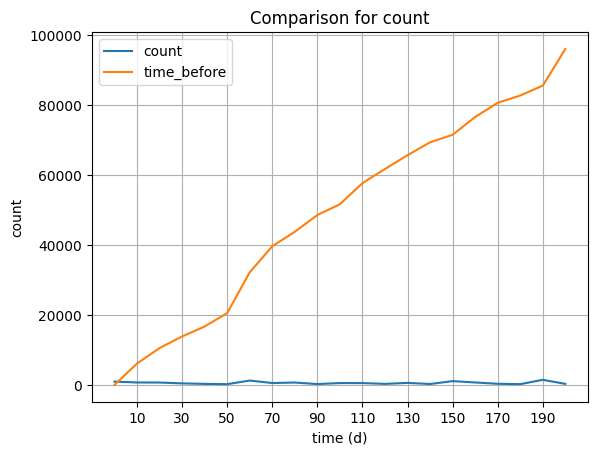

<Figure size 1000x600 with 0 Axes>

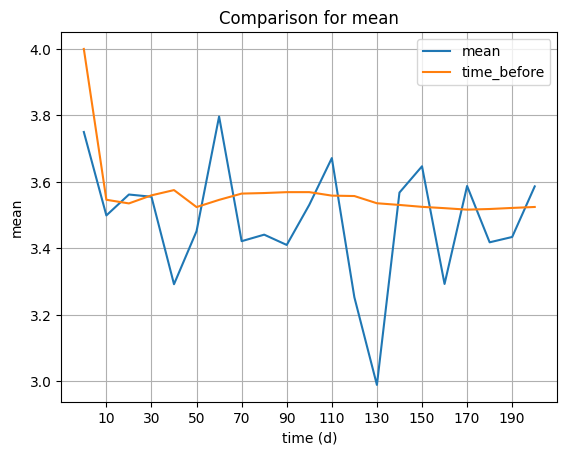

<Figure size 1000x600 with 0 Axes>

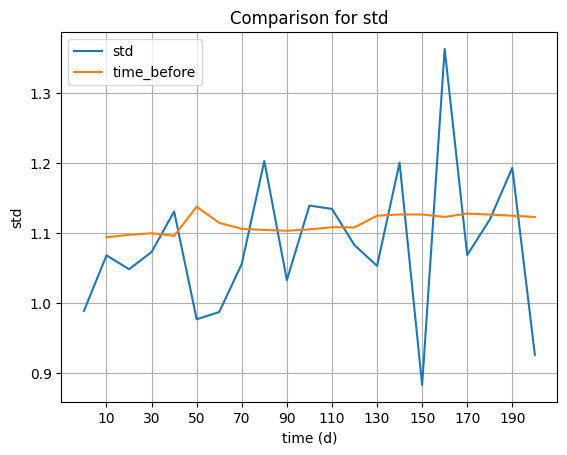

<Figure size 1000x600 with 0 Axes>

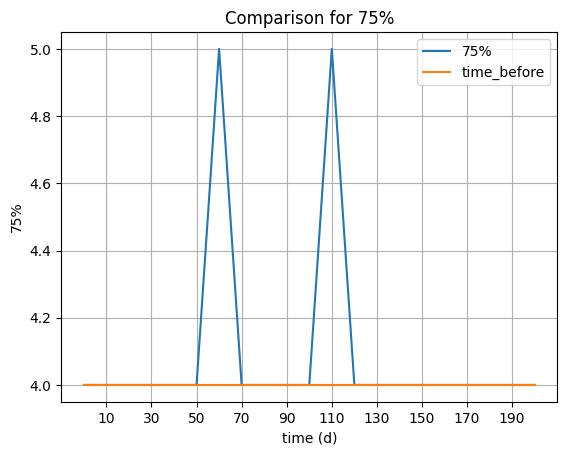

In [ ]:
for desc in ['count', 'mean', 'std', '75%']:
  value_list = []
  value_list2 = []
  day_list = list(range(0, 210, 10))
  for day in range(0, 210, 10):
    day_m = df_data['time'].min() + 86400 * day
    value_list.append(df_data.loc[(df_data['time'] > day_m) & (df_data['time'] < day_m + 86400)]['label'].describe()[desc])
    value_list2.append(df_data.loc[(df_data['time'] <= day_m)]['label'].describe()[desc])

  plt.figure(figsize=(10,6))

  fig, ax = plt.subplots()

  ax.plot(day_list, value_list, label=f'{desc}')
  ax.plot(day_list, value_list2, label=f'time_before')

  ax.set(xlabel='time (d)', ylabel=f'{desc}',
        title=f'Comparison for {desc}')
  ax.grid()
  ax.set_xticks((range(10, 210, 20)))

  # fig.savefig("test.png")
  plt.legend()
  plt.show()

In [ ]:
test_run4['40']

{'SVD': {'precision': 0.16666666666666666,
  'recall': 0.047926447574334896,
  'map': 0.2242476851851852,
  'ndcg': 0.2896617568867699,
  'train_time': 3.8219778190000397},
 'SVDpp': {'precision': 0.13333333333333333,
  'recall': 0.008621962382260017,
  'map': 0.15575396825396826,
  'ndcg': 0.2092122877422773,
  'train_time': 4.235125897999751},
 'ItemCF': {'precision': 0.13333333333333333,
  'recall': 0.028814923081465733,
  'map': 0.18939594356261025,
  'ndcg': 0.2917555358212361,
  'train_time': 0.22642295500008913},
 'UserCF': {'precision': 0.049999999999999996,
  'recall': 0.002347417840375587,
  'map': 0.12962962962962962,
  'ndcg': 0.15110460164140846,
  'train_time': 0.023390250999909767},
 'ALS': {'precision': 0.10000000000000002,
  'recall': 0.014143561579118315,
  'map': 0.11686507936507935,
  'ndcg': 0.18410580022395764,
  'train_time': 4.652555495999877}}

In [ ]:
train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1])
eval_data = DatasetPure.build_evalset(eval_data)
train_data, data_info = DatasetPure.build_trainset(train)
test_data = DatasetPure.build_testset(test)

def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):

  results = {}

  for algo in algos:
    print(algo)
    result = evaluate(model=algo, data=test_data, metrics=metrics, k=20)
    results[algo.__class__.__name__] = result

  return results

metrics = [
  "precision",
  "recall",
  "map",
  "ndcg",
]

reset_state("SVD")
svd = SVD(
    "ranking",
    data_info,
    embed_size=20,
    n_epochs=50,
    lr=0.001,
    reg=0.0001,
)

svd.fit(
    train_data,
    verbose=0,
    shuffle=False,
    # eval_data=eval_data,
    # metrics=metrics,
)

reset_state("SVD++")
svdpp = SVDpp(
    "ranking",
    data_info,
    loss_type="cross_entropy",
    embed_size=50,
    n_epochs=25,
    lr=0.001,
    reg=0.0001,
)

svdpp.fit(
    train_data,
    verbose=0,
    # eval_data=eval_data,
    # metrics=metrics,
)

reset_state("item_cf")
item_cf = ItemCF(
    task="ranking",
    data_info=data_info,
    k_sim=25,
    sim_type="pearson",
)

item_cf.fit(
    train_data,
    verbose=0,
    # eval_data=eval_data,
    # metrics=metrics,
)

reset_state("user_cf")
user_cf = UserCF(
    task="ranking",
    data_info=data_info,
    k_sim=50,
    sim_type="pearson",
)

user_cf.fit(
    train_data,
    verbose=0,
    # eval_data=eval_data,
    # metrics=metrics,
)

reset_state("ALS")
als = ALS(
    "ranking",
    data_info,
    embed_size=10,
    n_epochs=200,
    reg=5.0
)

als.fit(
    train_data,
    verbose=0,
    # eval_data=eval_data,
    # metrics=metrics,
)

algos = [svd, svdpp, als, item_cf, user_cf]

result = create_results(algos, test_data, metrics)

print(result)


 ============================== SVD ==============================
Training start time: 2023-04-04 12:43:50


train: 100%|██████████| 387/387 [00:00<00:00, 1038.20it/s]



 ============================== SVD++ ==============================
Training start time: 2023-04-04 12:44:11


train: 100%|██████████| 387/387 [00:02<00:00, 187.63it/s]



 ============================== item_cf ==============================
Training start time: 2023-04-04 12:45:02
Final block size and num: (1680, 1)
sim_matrix elapsed: 0.131s
sim_matrix, shape: (1680, 1680), num_elements: 1771614, density: 199.2259 %


top_k: 100%|██████████| 1680/1680 [00:00<00:00, 4311.94it/s]



 ============================== user_cf ==============================
Training start time: 2023-04-04 12:45:02
Final block size and num: (943, 1)
sim_matrix elapsed: 0.060s
sim_matrix, shape: (943, 943), num_elements: 853296, density: 95.9569 %


top_k: 100%|██████████| 943/943 [00:00<00:00, 4746.84it/s]



 ============================== ALS ==============================
Training start time: 2023-04-04 12:45:03


eval_listwise: 100%|██████████| 236/236 [00:00<00:00, 1202.03it/s]


eval_listwise: 100%|██████████| 236/236 [00:00<00:00, 1286.27it/s]


eval_listwise: 100%|██████████| 236/236 [00:00<00:00, 1840.90it/s]


eval_listwise: 100%|██████████| 236/236 [00:08<00:00, 27.42it/s]


eval_listwise: 100%|██████████| 236/236 [00:21<00:00, 11.02it/s]

{'SVD': {'precision': 0.005419766206163655, 'recall': 0.10839532412327312, 'map': 0.028166300388723673, 'ndcg': 0.045298074432087755}, 'SVDpp': {'precision': 0.005844845908607864, 'recall': 0.11689691817215728, 'map': 0.03272022164939587, 'ndcg': 0.05099651715815287}, 'ALS': {'precision': 0.009192348565356005, 'recall': 0.18384697130712008, 'map': 0.044290667157536934, 'ndcg': 0.07405223511998436}, 'ItemCF': {'precision': 0.004622741764080765, 'recall': 0.0924548352816153, 'map': 0.02836842293907434, 'ndcg': 0.04193841145431167}, 'UserCF': {'precision': 0.0004250797024442083, 'recall': 0.008501594048884165, 'map': 0.0016626144548567503, 'ndcg': 0.0030372939781753657}}


In [ ]:
test_figures4 = model_results(test_run4, metrics_ranking, 2, model_time=True)

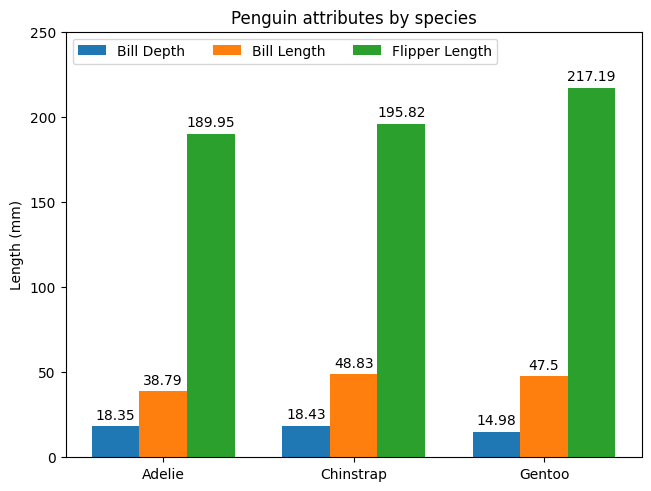

In [ ]:
for algorithm, algo_values in result.items():
  for metric, values in algo_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

species = ("Adelie", "Chinstrap", "Gentoo")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()

In [ ]:
result

{'SVD': {'precision': 0.006801275239107333,
  'recall': 0.06801275239107332,
  'map': 0.02546682860179141,
  'ndcg': 0.03522976023436723},
 'SVDpp': {'precision': 0.00818278427205101,
  'recall': 0.0818278427205101,
  'map': 0.03024138454531653,
  'ndcg': 0.04207258040678309},
 'ALS': {'precision': 0.010201912858661,
  'recall': 0.10201912858660998,
  'map': 0.03865104667442605,
  'ndcg': 0.05341823324420977},
 'ItemCF': {'precision': 0.004888416578108395,
  'recall': 0.048884165781083955,
  'map': 0.025321761719211237,
  'ndcg': 0.030893151817769613},
 'UserCF': {'precision': 0.0004250797024442083,
  'recall': 0.004250797024442083,
  'map': 0.001393316802456016,
  'ndcg': 0.0019969815603610597}}

In [ ]:
svd.__class__.__name__

'SVD'

In [ ]:
algos = [svd, svdpp, item_cf, user_cf, als]

results = {}

for algo in algos:
  accuracy = evaluate(model=algo, data=test_data, metrics=metrics)
  results[algo.__class__.__name__] = accuracy

eval_listwise: 100%|██████████| 236/236 [00:00<00:00, 1951.74it/s]


In [ ]:
print(results)

{'SVD': {'precision': 0.006801275239107333, 'recall': 0.06801275239107332, 'map': 0.02542550140849822, 'ndcg': 0.035195904143514145}, 'SVDpp': {'precision': 0.00818278427205101, 'recall': 0.0818278427205101, 'map': 0.03024138454531653, 'ndcg': 0.04207258040678309}, 'ItemCF': {'precision': 0.004888416578108395, 'recall': 0.048884165781083955, 'map': 0.025321761719211237, 'ndcg': 0.030893151817769613}, 'UserCF': {'precision': 0.0004250797024442083, 'recall': 0.004250797024442083, 'map': 0.001393316802456016, 'ndcg': 0.0019969815603610597}, 'ALS': {'precision': 0.010201912858661, 'recall': 0.10201912858660998, 'map': 0.03865104667442605, 'ndcg': 0.05341823324420977}}


In [ ]:
tf.compat.v1.reset_default_graph()

metrics = [
  "precision",
  "recall",
  "map",
  "ndcg",
]

als = ALS(
    "ranking",
    data_info,
    reg=5.0,
    # embed_size=20,
    # n_epochs=50,
    # lr=0.001,
    # reg=0.0001,
)



als.fit(
    train_data,
    verbose=0,
    eval_data=eval_data,
    metrics=metrics,
)

accuracy = evaluate(model=als, data=test_data, metrics=metrics)

Training start time: 2023-04-04 12:04:02


eval_listwise: 100%|██████████| 236/236 [00:00<00:00, 925.42it/s]


In [ ]:
print(accuracy)

{'precision': 0.010201912858661, 'recall': 0.10201912858660998, 'map': 0.03644468059983469, 'ndcg': 0.05160415822209243}
